In [2]:
import numpy as np

processed_data = np.load("../datasets/processed_data.npz", allow_pickle=True)

x_train = processed_data["x_train"]
y_train = processed_data["y_train"]
x_test = processed_data["x_test"]
y_test = processed_data["y_test"]
x_eval = processed_data["x_eval"]
y_eval = processed_data["y_eval"]

x_train_pca = np.load("../datasets/x_train_pca.npy")
x_test_pca = np.load("../datasets/x_test_pca.npy")
x_eval_pca = np.load("../datasets/x_eval_pca.npy")

In [3]:
# Speeding execution time using Intel(R) Extension for Scikit-learn
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [84]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def randomized_search_cv(estimator, param_distributions: dict):
    rand_search_cv = RandomizedSearchCV(
        estimator, 
        param_distributions, 
        scoring=["recall", "accuracy"], 
        refit="recall",
        cv=cv, 
        random_state=42, 
        n_jobs=-1
    )
    rand_search_cv_results = rand_search_cv.fit(x_train_pca, y_train)

    cv_results = rand_search_cv_results.cv_results_
    custom_scores = (cv_results["mean_test_recall"] * 1 + cv_results["mean_test_accuracy"]) / 3
    rank_test_score = custom_scores.argsort()[::-1] + 1

    best_index = rank_test_score.argmin()
    rand_search_cv_results.best_params_ = cv_results["params"][best_index]
    rand_search_cv_results.cv_results_["rank_test_score"] = rank_test_score
    return rand_search_cv_results

In [74]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cv_results(cv_results_: dict, title: str="") -> None:
    df = pd.DataFrame(cv_results_)
    df = df.sort_values(by="rank_test_score")

    pattern = re.compile(r"split[0-9]+_test_*")

    split_columns = [c for c in df.columns.values.tolist() if pattern.match(c)]

    # Picking only the columns to plot
    df = df[["params"] + split_columns]
    df["params"] = df["params"].astype(str)

    # Rotating the dataframe
    df = df.melt(id_vars="params", value_vars=split_columns)

    plt.figure(figsize=(10, 6))
    sns.boxplot(df, x="value", y="params", fliersize=0)
    plt.xlabel("Recall Score")
    plt.title(title)
    plt.show()

In [59]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
)
from src.utils.helpers import plot_confusion_matrix

models_scores = {}

# Evaluating a model from best params
def evaluate_model(model, cv):
    # set the params to be the best combination
    model_name = type(model).__name__
    model.set_params(**cv.best_params_)

    # train the model with the best params combination
    model.fit(x_train_pca, y_train)

    y_pred = model.predict(x_test_pca)

    models_scores[model_name] = {
        "recall": recall_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred)
    }

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

In [85]:
from sklearn.svm import SVC

svc = SVC()

param_distributions = {
    "C": [0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": list(range(1, 11)),  # Just for "poly"
}

svc_search = randomized_search_cv(svc, param_distributions)
svc_search.best_params_

{'kernel': 'rbf', 'degree': 7, 'C': 0.1}

In [86]:
%matplotlib inline

plot_cv_results(svc_search.cv_results_)

KeyError: 'rank_test_score'

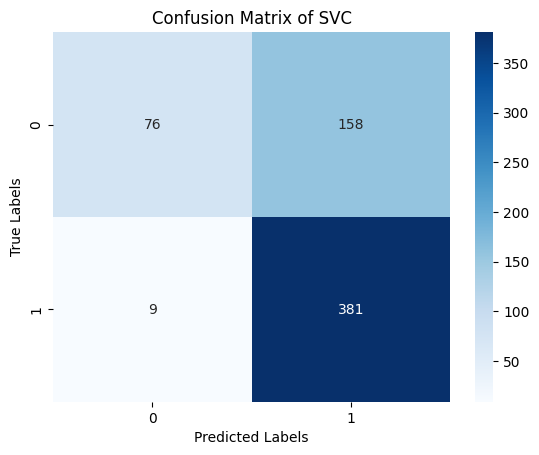

In [83]:
evaluate_model(svc, svc_search)